# Animal Classifier CNN

The following file will integrate a CNN aiming at using the `Animals-10` dataset in order to correctly classify them according to their species. Multiple different hyper parameters, transformations and models will be used through transfer learning to test out different configurations and determine which configuration leads to the best performance.

In order to maintain the code clean, the project will incorporate several helper functions, and will be modularized in the `utils` folder to keep the `main.ipynb` file as clean as possible.

Throughout the project, the structure can be seen in the outline where after setting up the foundations, the project will focus on tweaking parameters and assessing their performance through tensor board and our own manual prints.



## Data Setup

In [1]:
try:
    import torch
    import torchvision
    assert int(torch.__version__.split(".")[0]) >= 2, "torch version should be 2.+"
    assert int(torchvision.__version__.split(".")[1]) >= 15, "torchvision version should be 0.15+"
    print(f"torch version: {torch.__version__}")
    print(f"torchvision version: {torchvision.__version__}")
except:
    print(f"[INFO] torch/torchvision versions not correct. Installing correct versions.")
    !pip3 install -U torch torchvision torchaudio --extra-index-url https://download.pytorch.org/whl/cu113
    import torch
    import torchvision
    print(f"torch version: {torch.__version__}")
    print(f"torchvision version: {torchvision.__version__}")

from torch import nn
from torchvision import transforms
import matplotlib.pyplot as plt

try:
    from torchinfo import summary
except:
    print("[INFO] Couldn't find torchinfo... installing it")
    !pip install -q torchinfo
    from torchinfo import summary

try:
    from tqdm.auto import tqdm
except:
    print(f"[INFO] Couldnt't find tqdm... installing it ")
    !pip install tqdm
    from tqdm.auto import tqdm


torch version: 2.5.1+cu124
torchvision version: 0.20.1+cu124


In [2]:
try:
    from torchinfo import summary
except ImportError:
    print("[INFO] Couldn't find torchinfo... installing it")
    !pip install -q torchinfo
    from torchinfo import summary

try:
    import splitfolders
except ImportError:
    print("[INFO] Installing splitfolders...")
    !pip install -q split-folders
    import splitfolders


try:
    from torch.utils.tensorboard import SummaryWriter
except:
    print("[INFO] Couldn't find tensorboard... installing it.")
    !pip install -q tensorboard
    from torch.utils.tensorboard import SummaryWriter

try:
    from project_modules import data_setup, engine, get_data, model_builder, predictions, train, save_model, helper_functions
except ImportError:
    print("[INFO] Could not find project_modules scripts. Downloading them from GitHub.")
    !git clone https://github.com/Aaron-Serpilin/Animal-Classifier
    # Move both project modules and the data folder to the current directory
    !mv Animal-Classifier/project_modules .
    !mv Animal-Classifier/data .
    !rm -rf Animal-Classifier
    from project_modules import data_setup, engine, get_data, model_builder, predictions, train, save_model, helper_functions


Train and Test sets Ready.


In [3]:
device = "cuda" if torch.cuda.is_available() else "cpu"
device

'cuda'

In [4]:
from pathlib import Path

data_path = Path("data")
data_path

PosixPath('data')

In [5]:
import os

for dirpath, dirnames, filenames in os.walk(data_path):
  print(f"There are {len(dirnames)} directories and {len(filenames)} images in '{dirpath}'.")

There are 3 directories and 1 images in 'data'.
There are 10 directories and 0 images in 'data/test'.
There are 0 directories and 334 images in 'data/test/cat'.
There are 0 directories and 620 images in 'data/test/chicken'.
There are 0 directories and 525 images in 'data/test/horse'.
There are 0 directories and 374 images in 'data/test/cow'.
There are 0 directories and 364 images in 'data/test/sheep'.
There are 0 directories and 373 images in 'data/test/squirrel'.
There are 0 directories and 423 images in 'data/test/butterfly'.
There are 0 directories and 290 images in 'data/test/elephant'.
There are 0 directories and 973 images in 'data/test/dog'.
There are 0 directories and 965 images in 'data/test/spider'.
There are 10 directories and 1 images in 'data/raw-img'.
There are 0 directories and 1668 images in 'data/raw-img/cat'.
There are 0 directories and 3098 images in 'data/raw-img/rooster'.
There are 0 directories and 2623 images in 'data/raw-img/horse'.
There are 0 directories and 1

In [6]:
train_dir = data_path / "train"
test_dir = data_path / "test"

train_dir, test_dir

(PosixPath('data/train'), PosixPath('data/test'))

## Visualizing Images

In [7]:
def set_seeds (seed: int=42):
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)

In [8]:
import random
from PIL import Image

# For recreatability purposes
random.seed(42)
set_seeds()

image_path_list = list(data_path.glob("*/*/*.jpg"))
image_path_list

[PosixPath('data/test/cat/ea36b1082cf4063ed1584d05fb1d4e9fe777ead218ac104497f5c978a7eebdbb_640.jpg'),
 PosixPath('data/test/cat/eb3cb70c28f1063ed1584d05fb1d4e9fe777ead218ac104497f5c978a7e8b7bc_640.jpg'),
 PosixPath('data/test/cat/ee33b00e2ee90021d85a5854ee454296eb70e3c818b413449df1c17fa2ee_640.jpg'),
 PosixPath('data/test/cat/e835b40820f6083ed1584d05fb1d4e9fe777ead218ac104497f5c978a7eebdbb_640.jpg'),
 PosixPath('data/test/cat/ea35b90f21f2043ed1584d05fb1d4e9fe777ead218ac104497f5c978a7eebdbb_640.jpg'),
 PosixPath('data/test/cat/ea34b90f2efc013ed1584d05fb1d4e9fe777ead218ac104497f5c978a7e8b7bc_640.jpg'),
 PosixPath('data/test/cat/ea34b8062ffd073ed1584d05fb1d4e9fe777ead218ac104497f5c978a7ebb0bb_640.jpg'),
 PosixPath('data/test/cat/ea36b20a20f2033ed1584d05fb1d4e9fe777ead218ac104497f5c978a7eebdbb_640.jpg'),
 PosixPath('data/test/cat/ea37b90f2df0033ed1584d05fb1d4e9fe777ead218ac104497f5c978a7ebb0bb_640.jpg'),
 PosixPath('data/test/cat/ea37b70f20f6073ed1584d05fb1d4e9fe777ead218ac104497f5c978a7eb

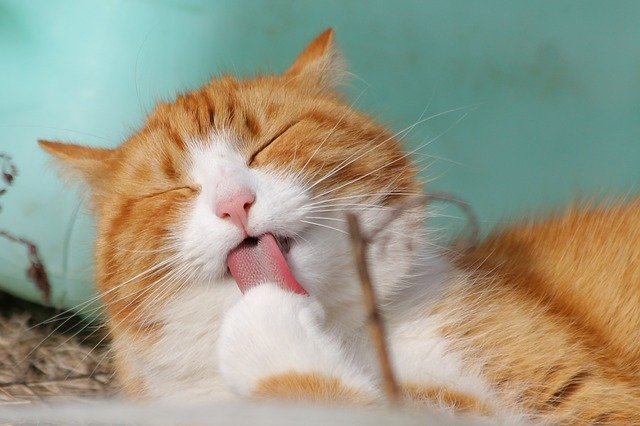

In [9]:
random_image_path = random.choice(image_path_list)
img = Image.open(random_image_path)
img

In [10]:
print(f"Image path: {random_image_path}")
print(f"Image height: {img.height}")
print(f"Image width: {img.width}")
print(f"Image class: {random_image_path.parent.stem}")

Image path: data/train/cat/ea37b20d2ef61c22d2524518b7444f92e37fe5d404b0144390f8c079a4e5b6_640.jpg
Image height: 426
Image width: 640
Image class: cat


## Preparing Data

In [11]:
from torch.utils.data import DataLoader
from torchvision import datasets, transforms

### Preparing Transformations

In [12]:
train_transform = transforms.Compose([
        transforms.Resize((224, 224)),
        transforms.RandomHorizontalFlip(p=0.5),
        transforms.RandomRotation(10),
        transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.1),
        transforms.RandomResizedCrop(size=(224, 224), scale=(0.8, 1.0)),
        transforms.RandomAffine(degrees=10, translate=(0.1, 0.1)),
        transforms.ToTensor(),
        transforms.Lambda(lambda img: img + 0.02 * torch.randn_like(img)), # Noise injection
        transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

grayscale_transform = transforms.Compose([
    transforms.Grayscale(num_output_channels=3)
])

test_transform = transforms.Compose([
    transforms.Resize(size=(64, 64)),
    transforms.ToTensor()
])

train_transform, test_transform

(Compose(
     Resize(size=(224, 224), interpolation=bilinear, max_size=None, antialias=True)
     RandomHorizontalFlip(p=0.5)
     RandomRotation(degrees=[-10.0, 10.0], interpolation=nearest, expand=False, fill=0)
     ColorJitter(brightness=(0.8, 1.2), contrast=(0.8, 1.2), saturation=(0.8, 1.2), hue=(-0.1, 0.1))
     RandomResizedCrop(size=(224, 224), scale=(0.8, 1.0), ratio=(0.75, 1.3333), interpolation=bilinear, antialias=True)
     RandomAffine(degrees=[-10.0, 10.0], translate=(0.1, 0.1))
     ToTensor()
     Lambda()
     Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
 ),
 Compose(
     Resize(size=(64, 64), interpolation=bilinear, max_size=None, antialias=True)
     ToTensor()
 ))

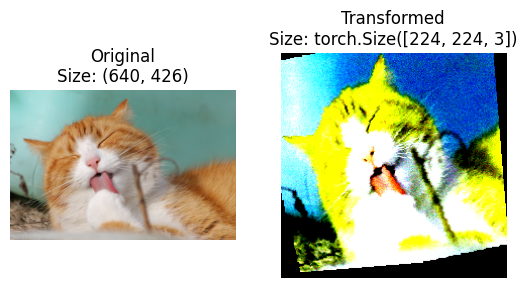

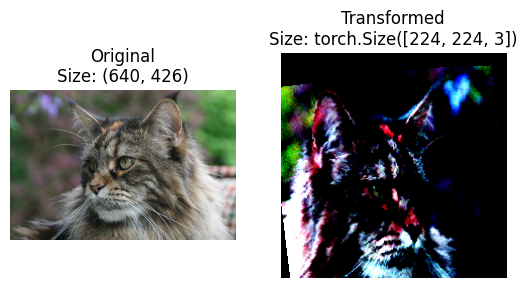

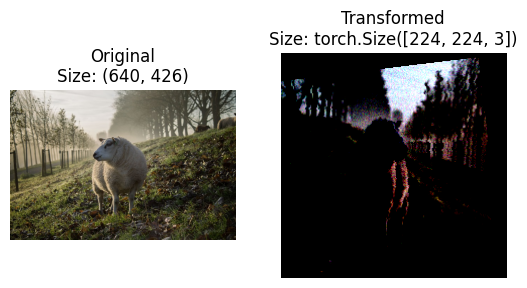

In [13]:
def plot_transformed_images(image_paths, transform, n=3, seed=42):

  if seed:
    random.seed(seed)
  random_image_paths = random.sample(image_paths, k=n)

  for image_path in random_image_paths:
    with Image.open(image_path) as f:
      fig, ax = plt.subplots(nrows=1, ncols=2)
      ax[0].imshow(f)
      ax[0].set_title(f"Original\nSize: {f.size}")
      ax[0].axis(False)

      transformed_image = transform(f).permute(1, 2, 0)
      ax[1].imshow(transformed_image)
      ax[1].set_title(f"Transformed\nSize: {transformed_image.shape}")
      ax[1].axis(False)

plot_transformed_images(image_path_list, train_transform)

### Preparing Image Folder, DataLoaders and Datasets

In [14]:
import os
from torch.utils.data import DataLoader
from project_modules.data_setup import create_dataloaders

BATCH_SIZE = 32
NUM_WORKERS = os.cpu_count()

train_dataloader, test_dataloader, class_names = create_dataloaders(
    train_dir,
    test_dir,
    train_transform,
    test_transform,
    BATCH_SIZE,
    NUM_WORKERS
    )

## Transfer Learning

The next section fetches the pre-trained models we aim to test. We then freeze their base layers and change the classifier head to match our problem.

We freeze the layers to prevent the model to continue learning and updating the weights during training. This prevents backpropagation from taking place during training, and allows the weights to retain their value. This way we preserve the pre-trained knowledge, avoid overfitting, and reduce computational cost.

To facilitate the development of the different models, we will use helper functions that do the following:
* Get the base model from `torchvision.models`
* Freeze the base layers
* Set the random seeds
* Change the classifier head
* Name the model

In [15]:
import torchvision
from torch import nn

def create_transfer_model(
        model,
        model_name,
        classifier_attr,
        in_features,
        out_features,
        freeze_layer_attr=None,
        dropout_rate=0.2,
        device=device):

    if freeze_layer_attr is not None:
        base_layers = getattr(model, freeze_layer_attr, None)
        if base_layers is not None:
            for param in base_layers.parameters():
                param.requires_grad = False
    else:
        # We freeze all parameters except those in the classifier attribute
        for name, param in model.named_parameters():
            if classifier_attr not in name:
                param.requires_grad = False

    set_seeds()

    new_classifier = nn.Sequential(
        nn.Dropout(p=dropout_rate),
        nn.Linear(in_features, out_features)
    ).to(device)
    setattr(model, classifier_attr, new_classifier)

    model.name = model_name
    print(f"[INFO] Created new {model.name} model")
    return model



In [16]:
OUT_FEATURES = len(class_names)
OUT_FEATURES

10

Our dataset has 11 different classes, meaning that when redefining the classifier head, they will all share the `OUT_FEATURES` value. However, in order to determine the `in_features` we need to print out the summary of each model and find it.

Below will be defined all the different models we will use and track to determine which one has the best performance on our dataset, and to determine within the given model which preprocessing combination is the best.

In [17]:
import torchvision
from torchinfo import summary

effnetb0_weights = torchvision.models.EfficientNet_B0_Weights.DEFAULT
effnetb0_model = torchvision.models.efficientnet_b0(weights=effnetb0_weights).to(device)

effnetb3_weights = torchvision.models.EfficientNet_B3_Weights.DEFAULT
effnetb3_model = torchvision.models.efficientnet_b3(weights=effnetb3_weights)

resnet18_weights = torchvision.models.ResNet18_Weights.DEFAULT
resnet18_model = torchvision.models.resnet18(weights=resnet18_weights)

resnet34_weights = torchvision.models.ResNet34_Weights.DEFAULT
resnet34_model = torchvision.models.resnet34(weights=resnet34_weights)

# Older and more parameter heavy, but useful baseline
vgg13_weights = torchvision.models.VGG13_Weights.DEFAULT
vgg13_model = torchvision.models.vgg13(weights=vgg13_weights)

vgg16_weights = torchvision.models.VGG16_Weights.DEFAULT
vgg16_model = torchvision.models.vgg16(weights=vgg16_weights)


In [18]:
summary(model=effnetb0_model,
        input_size=(32, 3, 224, 224),
        col_names=["input_size", "output_size", "num_params", "trainable"],
        col_width=20,
        row_settings=["var_names"])


Layer (type (var_name))                                      Input Shape          Output Shape         Param #              Trainable
EfficientNet (EfficientNet)                                  [32, 3, 224, 224]    [32, 1000]           --                   True
├─Sequential (features)                                      [32, 3, 224, 224]    [32, 1280, 7, 7]     --                   True
│    └─Conv2dNormActivation (0)                              [32, 3, 224, 224]    [32, 32, 112, 112]   --                   True
│    │    └─Conv2d (0)                                       [32, 3, 224, 224]    [32, 32, 112, 112]   864                  True
│    │    └─BatchNorm2d (1)                                  [32, 32, 112, 112]   [32, 32, 112, 112]   64                   True
│    │    └─SiLU (2)                                         [32, 32, 112, 112]   [32, 32, 112, 112]   --                   --
│    └─Sequential (1)                                        [32, 32, 112, 112]   [32, 16, 112

In [19]:
summary(model=effnetb3_model,
        input_size=(32, 3, 224, 224),
        col_names=["input_size", "output_size", "num_params", "trainable"],
        col_width=20,
        row_settings=["var_names"])

Layer (type (var_name))                                      Input Shape          Output Shape         Param #              Trainable
EfficientNet (EfficientNet)                                  [32, 3, 224, 224]    [32, 1000]           --                   True
├─Sequential (features)                                      [32, 3, 224, 224]    [32, 1536, 7, 7]     --                   True
│    └─Conv2dNormActivation (0)                              [32, 3, 224, 224]    [32, 40, 112, 112]   --                   True
│    │    └─Conv2d (0)                                       [32, 3, 224, 224]    [32, 40, 112, 112]   1,080                True
│    │    └─BatchNorm2d (1)                                  [32, 40, 112, 112]   [32, 40, 112, 112]   80                   True
│    │    └─SiLU (2)                                         [32, 40, 112, 112]   [32, 40, 112, 112]   --                   --
│    └─Sequential (1)                                        [32, 40, 112, 112]   [32, 24, 112

In [20]:
summary(model=resnet18_model,
        input_size=(32, 3, 224, 224),
        col_names=["input_size", "output_size", "num_params", "trainable"],
        col_width=20,
        row_settings=["var_names"])

Layer (type (var_name))                  Input Shape          Output Shape         Param #              Trainable
ResNet (ResNet)                          [32, 3, 224, 224]    [32, 1000]           --                   True
├─Conv2d (conv1)                         [32, 3, 224, 224]    [32, 64, 112, 112]   9,408                True
├─BatchNorm2d (bn1)                      [32, 64, 112, 112]   [32, 64, 112, 112]   128                  True
├─ReLU (relu)                            [32, 64, 112, 112]   [32, 64, 112, 112]   --                   --
├─MaxPool2d (maxpool)                    [32, 64, 112, 112]   [32, 64, 56, 56]     --                   --
├─Sequential (layer1)                    [32, 64, 56, 56]     [32, 64, 56, 56]     --                   True
│    └─BasicBlock (0)                    [32, 64, 56, 56]     [32, 64, 56, 56]     --                   True
│    │    └─Conv2d (conv1)               [32, 64, 56, 56]     [32, 64, 56, 56]     36,864               True
│    │    └─BatchN

In [21]:
summary(model=resnet34_model,
        input_size=(32, 3, 224, 224),
        col_names=["input_size", "output_size", "num_params", "trainable"],
        col_width=20,
        row_settings=["var_names"])

Layer (type (var_name))                  Input Shape          Output Shape         Param #              Trainable
ResNet (ResNet)                          [32, 3, 224, 224]    [32, 1000]           --                   True
├─Conv2d (conv1)                         [32, 3, 224, 224]    [32, 64, 112, 112]   9,408                True
├─BatchNorm2d (bn1)                      [32, 64, 112, 112]   [32, 64, 112, 112]   128                  True
├─ReLU (relu)                            [32, 64, 112, 112]   [32, 64, 112, 112]   --                   --
├─MaxPool2d (maxpool)                    [32, 64, 112, 112]   [32, 64, 56, 56]     --                   --
├─Sequential (layer1)                    [32, 64, 56, 56]     [32, 64, 56, 56]     --                   True
│    └─BasicBlock (0)                    [32, 64, 56, 56]     [32, 64, 56, 56]     --                   True
│    │    └─Conv2d (conv1)               [32, 64, 56, 56]     [32, 64, 56, 56]     36,864               True
│    │    └─BatchN

In [22]:
summary(model=vgg13_model,
        input_size=(32, 3, 224, 224),
        col_names=["input_size", "output_size", "num_params", "trainable"],
        col_width=20,
        row_settings=["var_names"])

Layer (type (var_name))                  Input Shape          Output Shape         Param #              Trainable
VGG (VGG)                                [32, 3, 224, 224]    [32, 1000]           --                   True
├─Sequential (features)                  [32, 3, 224, 224]    [32, 512, 7, 7]      --                   True
│    └─Conv2d (0)                        [32, 3, 224, 224]    [32, 64, 224, 224]   1,792                True
│    └─ReLU (1)                          [32, 64, 224, 224]   [32, 64, 224, 224]   --                   --
│    └─Conv2d (2)                        [32, 64, 224, 224]   [32, 64, 224, 224]   36,928               True
│    └─ReLU (3)                          [32, 64, 224, 224]   [32, 64, 224, 224]   --                   --
│    └─MaxPool2d (4)                     [32, 64, 224, 224]   [32, 64, 112, 112]   --                   --
│    └─Conv2d (5)                        [32, 64, 112, 112]   [32, 128, 112, 112]  73,856               True
│    └─ReLU (6)     

In [23]:
summary(model=vgg16_model,
        input_size=(32, 3, 224, 224),
        col_names=["input_size", "output_size", "num_params", "trainable"],
        col_width=20,
        row_settings=["var_names"])

Layer (type (var_name))                  Input Shape          Output Shape         Param #              Trainable
VGG (VGG)                                [32, 3, 224, 224]    [32, 1000]           --                   True
├─Sequential (features)                  [32, 3, 224, 224]    [32, 512, 7, 7]      --                   True
│    └─Conv2d (0)                        [32, 3, 224, 224]    [32, 64, 224, 224]   1,792                True
│    └─ReLU (1)                          [32, 64, 224, 224]   [32, 64, 224, 224]   --                   --
│    └─Conv2d (2)                        [32, 64, 224, 224]   [32, 64, 224, 224]   36,928               True
│    └─ReLU (3)                          [32, 64, 224, 224]   [32, 64, 224, 224]   --                   --
│    └─MaxPool2d (4)                     [32, 64, 224, 224]   [32, 64, 112, 112]   --                   --
│    └─Conv2d (5)                        [32, 64, 112, 112]   [32, 128, 112, 112]  73,856               True
│    └─ReLU (6)     

In [24]:
effnetb0 = create_transfer_model(
    model=effnetb0_model,
    model_name="effnetb0",
    classifier_attr="classifier",  # EfficientNet uses 'classifier'
    in_features=1280,
    out_features=OUT_FEATURES,
    freeze_layer_attr="features",    # Freeze the 'features' block
    dropout_rate=0.2,
    device=device
)

[INFO] Created new effnetb0 model


In [25]:
effnetb3 = create_transfer_model(
    model=effnetb3_model,
    model_name="effnetb3",
    classifier_attr="classifier",
    in_features=1536,
    out_features=OUT_FEATURES,
    freeze_layer_attr="features",
    dropout_rate=0.2,
    device=device
)

[INFO] Created new effnetb3 model


In [26]:
resnet18 = create_transfer_model(
    model=resnet18_model,
    model_name="resnet18",
    classifier_attr="fc",  # ResNet uses 'fc' for its final classifier
    in_features=512,
    out_features=OUT_FEATURES,
    freeze_layer_attr=None,  # ResNet does not have a 'features' attribute to freeze
    dropout_rate=0.2,
    device=device
)

[INFO] Created new resnet18 model


In [27]:
resnet34 = create_transfer_model(
    model=resnet34_model,
    model_name="resnet34",
    classifier_attr="fc",  # ResNet uses 'fc'
    in_features=512,
    out_features=OUT_FEATURES,
    freeze_layer_attr=None,  # No 'features' attribute for ResNet
    dropout_rate=0.2,
    device=device
)

[INFO] Created new resnet34 model


In [28]:
vgg13 = create_transfer_model(
    model=vgg13_model,
    model_name="vgg13",
    classifier_attr="classifier",  # VGG uses 'classifier'
    in_features=25088,
    out_features=OUT_FEATURES,
    freeze_layer_attr="features",    # Freeze the 'features' block
    dropout_rate=0.2,
    device=device
)

[INFO] Created new vgg13 model


In [29]:
vgg16 = create_transfer_model(
    model=vgg16_model,
    model_name="vgg16",
    classifier_attr="classifier",
    in_features=25088,
    out_features=OUT_FEATURES,
    freeze_layer_attr="features",
    dropout_rate=0.2,
    device=device
)

[INFO] Created new vgg16 model


To have a reference as to how the parameter freezing affected the model backbones, we will use the summary of our new models.

In [31]:
summary(model=effnetb0,
        input_size=(32, 3, 224, 224),
        col_names=["input_size", "output_size", "num_params", "trainable"],
        col_width=20,
        row_settings=["var_names"])

Layer (type (var_name))                                      Input Shape          Output Shape         Param #              Trainable
EfficientNet (EfficientNet)                                  [32, 3, 224, 224]    [32, 10]             --                   Partial
├─Sequential (features)                                      [32, 3, 224, 224]    [32, 1280, 7, 7]     --                   False
│    └─Conv2dNormActivation (0)                              [32, 3, 224, 224]    [32, 32, 112, 112]   --                   False
│    │    └─Conv2d (0)                                       [32, 3, 224, 224]    [32, 32, 112, 112]   (864)                False
│    │    └─BatchNorm2d (1)                                  [32, 32, 112, 112]   [32, 32, 112, 112]   (64)                 False
│    │    └─SiLU (2)                                         [32, 32, 112, 112]   [32, 32, 112, 112]   --                   --
│    └─Sequential (1)                                        [32, 32, 112, 112]   [32, 

In [32]:
summary(model=effnetb3,
        input_size=(32, 3, 224, 224),
        col_names=["input_size", "output_size", "num_params", "trainable"],
        col_width=20,
        row_settings=["var_names"])

Layer (type (var_name))                                      Input Shape          Output Shape         Param #              Trainable
EfficientNet (EfficientNet)                                  [32, 3, 224, 224]    [32, 10]             --                   Partial
├─Sequential (features)                                      [32, 3, 224, 224]    [32, 1536, 7, 7]     --                   False
│    └─Conv2dNormActivation (0)                              [32, 3, 224, 224]    [32, 40, 112, 112]   --                   False
│    │    └─Conv2d (0)                                       [32, 3, 224, 224]    [32, 40, 112, 112]   (1,080)              False
│    │    └─BatchNorm2d (1)                                  [32, 40, 112, 112]   [32, 40, 112, 112]   (80)                 False
│    │    └─SiLU (2)                                         [32, 40, 112, 112]   [32, 40, 112, 112]   --                   --
│    └─Sequential (1)                                        [32, 40, 112, 112]   [32, 

In [33]:
summary(model=resnet18,
        input_size=(32, 3, 224, 224),
        col_names=["input_size", "output_size", "num_params", "trainable"],
        col_width=20,
        row_settings=["var_names"])

Layer (type (var_name))                  Input Shape          Output Shape         Param #              Trainable
ResNet (ResNet)                          [32, 3, 224, 224]    [32, 10]             --                   Partial
├─Conv2d (conv1)                         [32, 3, 224, 224]    [32, 64, 112, 112]   (9,408)              False
├─BatchNorm2d (bn1)                      [32, 64, 112, 112]   [32, 64, 112, 112]   (128)                False
├─ReLU (relu)                            [32, 64, 112, 112]   [32, 64, 112, 112]   --                   --
├─MaxPool2d (maxpool)                    [32, 64, 112, 112]   [32, 64, 56, 56]     --                   --
├─Sequential (layer1)                    [32, 64, 56, 56]     [32, 64, 56, 56]     --                   False
│    └─BasicBlock (0)                    [32, 64, 56, 56]     [32, 64, 56, 56]     --                   False
│    │    └─Conv2d (conv1)               [32, 64, 56, 56]     [32, 64, 56, 56]     (36,864)             False
│    │    

In [34]:
summary(model=resnet34,
        input_size=(32, 3, 224, 224),
        col_names=["input_size", "output_size", "num_params", "trainable"],
        col_width=20,
        row_settings=["var_names"])

Layer (type (var_name))                  Input Shape          Output Shape         Param #              Trainable
ResNet (ResNet)                          [32, 3, 224, 224]    [32, 10]             --                   Partial
├─Conv2d (conv1)                         [32, 3, 224, 224]    [32, 64, 112, 112]   (9,408)              False
├─BatchNorm2d (bn1)                      [32, 64, 112, 112]   [32, 64, 112, 112]   (128)                False
├─ReLU (relu)                            [32, 64, 112, 112]   [32, 64, 112, 112]   --                   --
├─MaxPool2d (maxpool)                    [32, 64, 112, 112]   [32, 64, 56, 56]     --                   --
├─Sequential (layer1)                    [32, 64, 56, 56]     [32, 64, 56, 56]     --                   False
│    └─BasicBlock (0)                    [32, 64, 56, 56]     [32, 64, 56, 56]     --                   False
│    │    └─Conv2d (conv1)               [32, 64, 56, 56]     [32, 64, 56, 56]     (36,864)             False
│    │    

In [35]:
summary(model=vgg13,
        input_size=(32, 3, 224, 224),
        col_names=["input_size", "output_size", "num_params", "trainable"],
        col_width=20,
        row_settings=["var_names"])

Layer (type (var_name))                  Input Shape          Output Shape         Param #              Trainable
VGG (VGG)                                [32, 3, 224, 224]    [32, 10]             --                   Partial
├─Sequential (features)                  [32, 3, 224, 224]    [32, 512, 7, 7]      --                   False
│    └─Conv2d (0)                        [32, 3, 224, 224]    [32, 64, 224, 224]   (1,792)              False
│    └─ReLU (1)                          [32, 64, 224, 224]   [32, 64, 224, 224]   --                   --
│    └─Conv2d (2)                        [32, 64, 224, 224]   [32, 64, 224, 224]   (36,928)             False
│    └─ReLU (3)                          [32, 64, 224, 224]   [32, 64, 224, 224]   --                   --
│    └─MaxPool2d (4)                     [32, 64, 224, 224]   [32, 64, 112, 112]   --                   --
│    └─Conv2d (5)                        [32, 64, 112, 112]   [32, 128, 112, 112]  (73,856)             False
│    └─ReLU (

In [36]:
summary(model=vgg16,
        input_size=(32, 3, 224, 224),
        col_names=["input_size", "output_size", "num_params", "trainable"],
        col_width=20,
        row_settings=["var_names"])

Layer (type (var_name))                  Input Shape          Output Shape         Param #              Trainable
VGG (VGG)                                [32, 3, 224, 224]    [32, 10]             --                   Partial
├─Sequential (features)                  [32, 3, 224, 224]    [32, 512, 7, 7]      --                   False
│    └─Conv2d (0)                        [32, 3, 224, 224]    [32, 64, 224, 224]   (1,792)              False
│    └─ReLU (1)                          [32, 64, 224, 224]   [32, 64, 224, 224]   --                   --
│    └─Conv2d (2)                        [32, 64, 224, 224]   [32, 64, 224, 224]   (36,928)             False
│    └─ReLU (3)                          [32, 64, 224, 224]   [32, 64, 224, 224]   --                   --
│    └─MaxPool2d (4)                     [32, 64, 224, 224]   [32, 64, 112, 112]   --                   --
│    └─Conv2d (5)                        [32, 64, 112, 112]   [32, 128, 112, 112]  (73,856)             False
│    └─ReLU (

For Markdown tables, we use the following generator:
https://www.tablesgenerator.com/markdown_tables


| Model    | Total parameters (before freezing/changing head) | Total parameters (after freezing/changing head) | Total trainable parameters (after freezing/changing head) |
|----------|--------------------------------------------------|-------------------------------------------------|-----------------------------------------------------------|
| effnetb0 | 5,288548                                         | 4,021,639                                       | 14,091                                                    |
| effnetb3 | 12,233,232                                       | 10,713,139                                      | 16,907                                                    |
| resnet18 | 11,689,512                                       | 11,182,155                                      | 5,643                                                     |
| resnet34 | 21,797,672                                       | 21,290,315                                      | 5,643                                                     |
| vgg13    | 133,047,848                                      | 9,680,971                                       | 275,979                                                   |
| vgg16    | 138,357,544                                      | 14,990,667                                      | 275,979                                                   |

## Model Tracking

In the following section we set up PyTorch's `torch.utils.tensorboard.SummaryWriter()` to save the multiple parts of the model's training progress. We can then compare said saved files to identify the best performing parameter combination.

In [37]:
writer = SummaryWriter()

Once we start training our models and experiment tracking, we would need to define a writer for each loop of the different models and the epochs. Hence, we will make a helper function that produces a `SummaryWriter()` that tracks to a custom `log_dir`

The name formatting for our `log_dir` will be `runs/YYYY-MM-DD/exxperiment_name/model_name/extra`

In [39]:
def create_writer(experiment_name: str,
                  model_name: str,
                  extra: str=None) -> torch.utils.tensorboard.writer.SummaryWriter():

                  from datetime import datetime
                  import os

                  timestamp = datetime.now().strftime("%Y-%m-%d--%H:%M:%S")

                  if extra:
                       log_dir = os.path.join("runs", timestamp, experiment_name, model_name, extra) # Create the log directory path
                  else:
                       log_dir = os.path.join("runs", timestamp, experiment_name, model_name) # Create the log directory path

                  print(f"[INFO] Created SummaryWriter, saving to: {log_dir}")
                  return SummaryWriter(log_dir=log_dir)

Furthermore, before training the entire dataset, it might be useful to first work with a smaller subset of the data. We can sart with 25%.

In [46]:
data_path, class_names

(PosixPath('data'),
 ['butterfly',
  'cat',
  'chicken',
  'cow',
  'dog',
  'elephant',
  'horse',
  'sheep',
  'spider',
  'squirrel'])

In [52]:
import os

total_train = sum(len(os.listdir(train_dir / class_name)) for class_name in class_names)
total_test = sum(len(os.listdir(test_dir / class_name)) for class_name in class_names)

print("Total train images:", total_train)
print("Total test images:", total_test)

Total train images: 20938
Total test images: 5241


In [62]:
import os
import shutil
import random
from pathlib import Path

for split in ["train", "test"]:
    small_split = f"{split}_small"
    small_dir = data_path / small_split

    # If the dir exists, we remove it and restart it to get a new small_split and not accumulate from previous runs
    if small_dir.exists():
        shutil.rmtree(small_dir)
    os.makedirs(small_dir)

    for class_name in class_names:
        src_class_dir = data_path / split / class_name
        dest_class_dir = small_dir / class_name
        os.makedirs(dest_class_dir, exist_ok=True)

        images = os.listdir(src_class_dir)
        num_to_copy = max(1, len(images) // 4)
        chosen_images = random.sample(images, num_to_copy)

        for img in chosen_images:
            src_path = os.path.join(src_class_dir, img)
            dest_path = os.path.join(dest_class_dir, img)
            shutil.copy(src_path, dest_path)

print("Created train_small and test_small directories with a quarter of the images each.")


Created train_small and test_small directories with a quarter of the images each.


In [61]:
train_small_dir = data_path / "train_small"
test_small_dir = data_path / "test_small"

total_train_small = sum(len(os.listdir(train_small_dir / class_name)) for class_name in class_names)
total_test_small = sum(len(os.listdir(test_small_dir / class_name)) for class_name in class_names)

print("Total train_small images:", total_train_small)
print("Total test_small images:", total_test_small)


Total train_small images: 5232
Total test_small images: 1307


Now we can setup our code for experiment tracking.

In [63]:
train_transform, test_transform, grayscale_transform

(Compose(
     Resize(size=(224, 224), interpolation=bilinear, max_size=None, antialias=True)
     RandomHorizontalFlip(p=0.5)
     RandomRotation(degrees=[-10.0, 10.0], interpolation=nearest, expand=False, fill=0)
     ColorJitter(brightness=(0.8, 1.2), contrast=(0.8, 1.2), saturation=(0.8, 1.2), hue=(-0.1, 0.1))
     RandomResizedCrop(size=(224, 224), scale=(0.8, 1.0), ratio=(0.75, 1.3333), interpolation=bilinear, antialias=True)
     RandomAffine(degrees=[-10.0, 10.0], translate=(0.1, 0.1))
     ToTensor()
     Lambda()
     Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
 ),
 Compose(
     Resize(size=(64, 64), interpolation=bilinear, max_size=None, antialias=True)
     ToTensor()
 ),
 Compose(
     Grayscale(num_output_channels=3)
 ))

In [66]:
BATCH_SIZE = 32
NUM_WORKERS = os.cpu_count()

train_dataloader_25_percent, test_dataloader_25_percent, class_names = create_dataloaders(
    train_dir=train_small_dir,
    test_dir=test_small_dir,
    train_transform=train_transform,
    test_transform=test_transform,
    batch_size = BATCH_SIZE,
    num_workers=NUM_WORKERS,
    )

print(f"Number of batches of size {BATCH_SIZE} in the training set: {len(train_dataloader_25_percent)}")
print(f"Number of batches of size {BATCH_SIZE} in the test set: {len(test_dataloader_25_percent)}")

Number of batches of size 32 in the training set: 164
Number of batches of size 32 in the test set: 41


In [ ]:
num_epochs = [5]

models = ["effnetb0", "effnetb3", "resnet18", "resnet34", "vgg13" ,"vgg16"]

In [74]:
%%time
from project_modules.engine import train as train_model

set_seeds()
experiment_number = 0

def process_model (model_name: str):
  match model_name:
          case "effnetb0":
              return effnetb0
          case "effnetb3":
              return effnetb3
          case "resnet18":
              return resnet18
          case "resnet34":
              return resnet34
          case "vgg13":
              return vgg13
          case "vgg16":
              return vgg16
          case _:
            print(f"[ERROR] Wrong model input")
            return


for epochs in num_epochs:
  for model_name in models:
      experiment_number += 1
      print(f"[INFO] Experiment number: {experiment_number}")
      print(f"[INFO] Model: {model_name}")
      print(f"[INFO] Epochs: {epochs}")

      model = process_model(model_name)

      loss_fn = nn.CrossEntropyLoss()
      optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

      train_model.train(model=model,
            train_dataloader=train_dataloader_25_percent,
            test_dataloader=test_dataloader_25_percent,
            optimizer=optimizer,
            loss_fn=loss_fn,
            epochs=epochs,
            device=device,
            writer=create_writer(experiment_name="train_dataloader_25_percent",
                                 model_name=model_name,
                                 extra=f"{epochs}_epochs"))

      save_model(model=model,
                 target_dir="models",
                 model_name=f"{model_name}_train_dataloader_25_percent_{epochs}_epochs.pth")
      print("-"*50 + "\n")





[INFO] Experiment number: 1
[INFO] Model: effnetb0
[INFO] Epochs: 5
[INFO] Created SummaryWriter, saving to: runs/2025-03-11--16:10:38/train_dataloader_25_percent/effnetb0/5_epochs


  0%|          | 0/5 [00:00<?, ?it/s]

Epoch: 1 | train_loss: 0.325 | train_acc: 0.902 | test_loss: 0.571 | test_acc: 0.119
Epoch: 2 | train_loss: 0.293 | train_acc: 0.911 | test_loss: 0.667 | test_acc: 0.136
Epoch: 3 | train_loss: 0.294 | train_acc: 0.911 | test_loss: 0.507 | test_acc: 0.121
Epoch: 4 | train_loss: 0.294 | train_acc: 0.907 | test_loss: 0.425 | test_acc: 0.130
Epoch: 5 | train_loss: 0.281 | train_acc: 0.911 | test_loss: 0.343 | test_acc: 0.123


TypeError: 'module' object is not callable